# Reconstruction of blurred images using the $H^1$ regularization

Welcome to the lab for the lecture on inverse and ill-posed problems! 

During this lab, we will try to implement the algorithm for the solution of classical ill-posed inverse problem of mathematical physics: reconstruction of blurred (defocused) images. 

Mathematically, the blurring is being described with the convolution operation. The problem of blurred images reconstruction can be reduced to a Fredholm integral equation of the first kind. 

Consider the frame 

$$
    P = \{ (x,y): |x|\le 1, |y|\le 1\}
$$

Both original and blurred images are presented with distributions of the brightnes of Red, Green and Blue colors over the frame $P$. In the current work, for simplicity, we consider the gray images, so that they could be presented with just level of white color at every pixel. 

Let $z(x,y), (x,y)\in P$ be a sharp image, and $u(x,y), (x,y)\in P$ be a blurred one. The equation to connect these images is: 

$$
			u(x,y) = Az \equiv K\ast z = b, \quad (K\ast z)(x,y) \equiv \int\limits_{P} z(\xi, \eta) k(x - \xi, y-\eta) d\xi d\eta,
$$

where the convolution kernel $k(x,y)$ represents the Point Spread Function (PSF). 
        
## Ill-posedness

* Convolution theorem: $\tilde{K}\tilde{f} = \tilde{b}$, where $\tilde{*}$ denotes the Fourier transform. 
* Why cannot we calculate just a $f = F^{-1} \big(\frac{\tilde{b}}{\tilde{K}}\big)$? 
* The Fourier image of the finite function (the function with bounded support area) is not a finite function. 
* Since both functions $b$ and $K$ are defined only inside the frame $P$ **(finite!!!)**, we can't predict the behavior of integral: 
$$
		f = F^{-1}\Bigg(\frac{\tilde{b}}{\tilde{K}}\Bigg) \equiv \iint\limits_{-\infty}^{\infty} \frac{\tilde{b}(\omega)}{\tilde{K}(\omega)} e^{i\omega\cdot x} d\omega.
$$


During this lab, we will: 
* Create the blurring function allowing us to construct the simulated data.
* Implement the algorithm for reconstruction of blurred images via minimization of Tikhonov's regularizing functional.
* Try the algorithm on both simulated and real blurred images. Real blurred images are defocused photographs.
* Investigate the influence of the regularization parameter. 


### Loading necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import scipy

### Loading the image
In order to simplify the task, we are resizing the image and transform it to the gray one, and normilize the obtained colormap with respect to 1. In real-world application it is better, however, to do it more accurate. The image can be reconstructed in the RGB palette. Each color should be reconstructed in the same way, but the regularization parameter for different colors may differ. 

In [2]:
def load_image(filename, N):
    img = plt.imread(filename)
    print('original size: '+str(img.shape))
    img = resize(img, (N,N))[:,:,0:3]

    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]

    res = np.sqrt(R**2 + G**2 + B**2)
    res = res/np.max(res)
    return res

# The kernel

Here we form the kernel. The kernel (the Point-spread-function, or PSF) must be formed with respect to the concrete problem.  For example, the PSF for defocusation of photos taken with mirror camera may be represented with a ring 
\begin{equation*}
    k(x,y) = \begin{cases} 
        \frac{1}{\pi r^2}, & x^2 + y^2 = r^2, \\ 
        0, & \text{elsewhere},
        \end{cases}
\end{equation*}

while in the electron microscopy we use a smooth PSF represented with the normal distribution

$$
	k(x,y) = Az \equiv \frac{1}{2\pi r^2} exp\Big(-\frac{x^2 + y^2}{2r^2} \Big).
$$

In the current work, however, we will use the simplest PSF, which is common for defocused photographs (taken with common, non mirrorring camera): just a circle in a frame $P = [-1,1] \times [-1,1]$. 

\begin{equation*}
    k(x,y) = \begin{cases} 
        \frac{1}{\pi r^2}, & x^2 + y^2 \le r^2 \\ 
        0, & \text{elsewhere}
        \end{cases}
\end{equation*}

### Task: implement the kernel above. 
The function should take two arguments. r is the radius of the kernel, and N is a size of array over one axis. Since in the function 'load_image' we resized the image to have a size $N\times N$, let the kernel have the same size. 

In real applications, it is better to use smaller kernels, which saves the time for modelling; here we will use the kernel with the same size.

In [3]:
def kernel(r, N):
    x, y = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))
    k = np.zeros((N, N))
    k[np.where(x**2 + y**2 <= r**2)] = 1.0/(N*np.pi*r**2)
    return k

## Test the kernel

Here you should see the circle at the origin

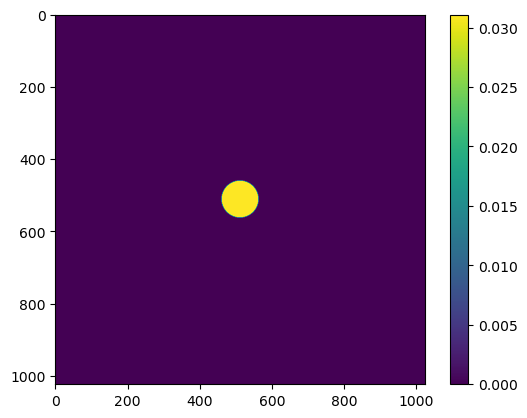

In [4]:
r = 0.1
N = 1024

k = kernel(r, N)
plt.imshow(k)
plt.colorbar()
plt.show()

### Blurring (convolution)

In the current section, let's implement a simple function for blurring the image. 

\begin{equation*}
   u(x,y) = \iint\limits_{B} z(x,y) k(x-\xi,y-\eta) d\xi d\eta
\end{equation*}

Since the convolution operation is rather slow, it is better to use the Convolution theorem: 

$$ 
    u = F^{-1}\big(\tilde{k}\tilde{z}\big), 
$$

where $\tilde{\cdot}$ denotes the Fourier transform of the function $\cdot$. 

Be careful: result of the inverse FT is complex (formally, imaginary part is almost zero). Thus, return only the real part. 

In [5]:
def blurring(image, kernel):
    #res = fftconvolve(image, kernel, mode='same')
    Z = scipy.fft.fftn(image)
    K = scipy.fft.fftn(kernel)
    u = scipy.fft.fftshift(np.real(scipy.fft.ifftn(Z*K)))
    return u

## Test the blurring

original size: (424, 640, 3)


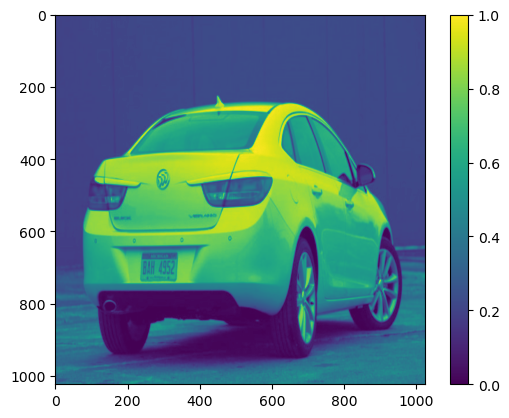

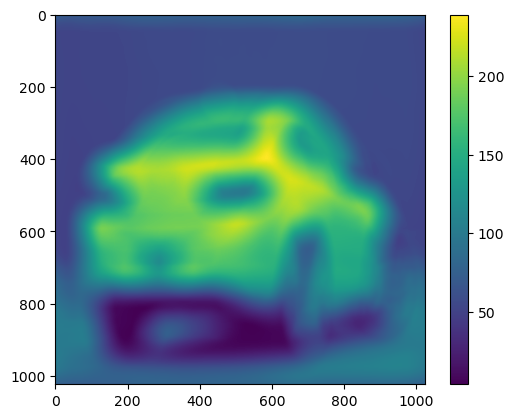

In [6]:
kernel_radius = 0.1
N = 1024

gt = load_image('test.png', N)
k = kernel(kernel_radius, N)
u = blurring(gt, k)
plt.imshow(gt)
plt.colorbar()
plt.show()

plt.imshow(u)
plt.colorbar()
plt.show()

# Deblurring

The governing equation: 
    
\begin{equation}
		u(x,y) = z(x,y) \ast k(x,y) \equiv \int\limits_{B} z(\xi,\eta) k(x-\xi,y-\eta)d\xi d\eta, 
\end{equation}
  
The cost Tikhonov's functional: 
$$
	M_{\alpha}[z] = ||Az - u||^2 + \alpha \Omega[z],
$$
	where the functional $\Omega[z]$ is a stabilizer. 
    
Let's regularize the problem in the space of smooth functions: the Sobolev's space $H^1$
    
$$
		\Omega(u) = ||u||_{H^1}^2 = ||u||_{L^2}^2 + \sum\limits_{i=1}^n ||\frac{\partial u}{\partial x_i}||_{L^2}^2
$$

Due to Parseval's theorem, $||f|| = ||\hat{f}||$. In terms of Fourier images, the cost functional takes the form: 

$$
		M(u) = ||\hat{k}\hat{u} - \hat{f}||_{L^2}^2 + \alpha ||\hat{u}||_{H^1}^2.
$$

The Frechet derivative (using the Parseval's equality together with FT properties): 

$$
		M'(u) = 2(\hat{k}^*\hat{k}\hat{u} - \hat{k}^*\hat{f}) + 2\alpha\hat{u}(1 - w^2 - \lambda^2)
$$

The functional is linear; thus, in order to find its minimizer, we can put its gradient to zero in order to obtain the so-called Euler's equation. The latter can be easily found directly allowing us to write the equation: 

$$
	\alpha(\hat{u} - \omega^2 \hat{u} - \lambda^2\hat{u}) + |\hat{k}|^2 \hat{u} - \hat{f} \hat{k}^* = 0.
$$

From the equation above we find the approximate solution (discretized): 

$$
		\hat{u} = \frac{\hat{f}\hat{k}^*}{|\hat{k}|^2 + \alpha (1 - \omega^2 - \lambda^2)}.
$$

Applying to the last result the inverse Fourier transform, we obtain the approximate solution (deconvolution result). 
    
### Task: implement the deblurring function. 
The arguments of the function: the blurred image $u(x,y)$, the kernel (PSF) $k(x,y)$, regularization parameter $\alpha$. 


In [7]:
def deblurring(u, k, alpha):
    N = u.shape[0]
    w1 = np.linspace(-1.0/(8*np.pi**2), 1.0/(8*np.pi**2), N)
    f1,f2 = np.meshgrid(w1,w1)
    
    U = np.fft.fft2(u)/N**2
    K = np.fft.fft2(k)/N**2
    K_conj = np.conjugate(K)
    
    Z = (K_conj*U) /(K_conj * K + alpha*(1 - f1**2 - f2**2))
    z = np.fft.ifft2(Z)
    z = np.fft.fftshift(z)
    return np.real(z)

## Test deblurring (without noise)

Here we test the implemented deblurring function with simulated data without noise. You can play with size $N$, kernel radius (dispersion) $r$, and with the regularization parameter $\alpha$

original size: (424, 640, 3)


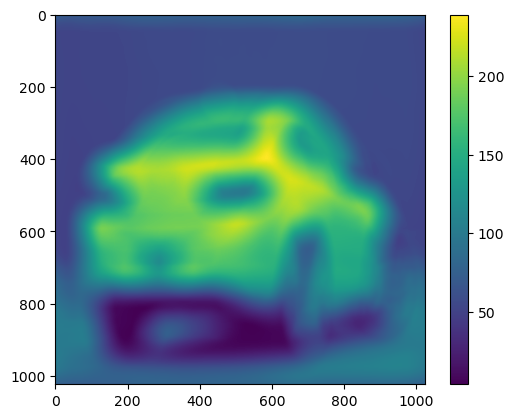

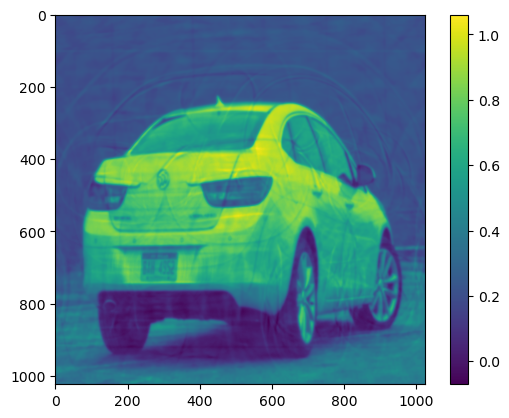

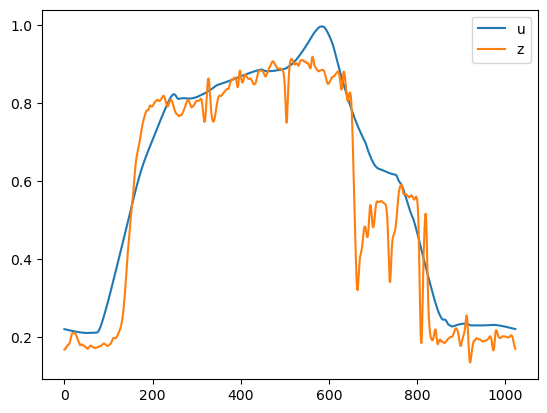

In [8]:
r = 0.1
N = 1024
z = load_image('test.png', N)
k = kernel(r, N)
u = blurring(z, k)

alpha = 5e-12

z = deblurring(u, k, alpha)

plt.imshow(u)
plt.colorbar()
plt.show()
plt.imshow(z)
plt.colorbar()
plt.show()

prof_gt = z[400,:]/np.max(z)
prof_u = u[400,:]/np.max(u)
prof_z = z[400,:]/np.max(z)


#plt.plot(prof_gt, label='gt')
plt.plot(prof_u, label='u')
plt.plot(prof_z, label='z')
plt.legend()
plt.show()

## Test the deblurring on noisy data

original size: (424, 640, 3)


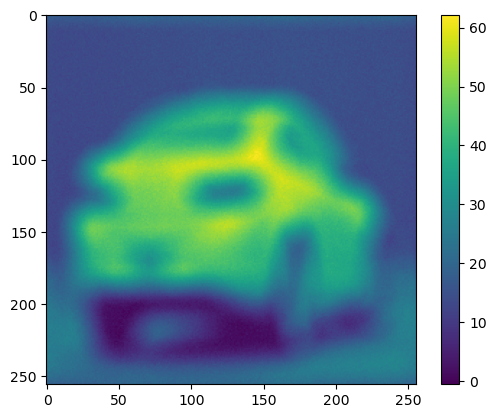

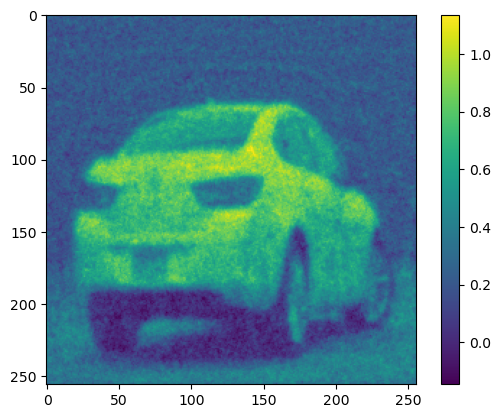

IndexError: index 400 is out of bounds for axis 0 with size 256

In [13]:
r = 0.1
N = 256
z = load_image('test.png', N)
k = kernel(r, N)
u = blurring(z, k)


noise_level = 0.01

u = u + noise_level*np.max(u)*np.random.randn(N,N)

alpha = 2e-9

z = deblurring(u, k, alpha)
plt.imshow(u)
plt.colorbar()
plt.show()
plt.imshow(z)
plt.colorbar()
plt.show()

prof_gt = z[400,:]/np.max(z)
prof_u = u[400,:]/np.max(u)
prof_z = z[400,:]/np.max(z)


plt.plot(prof_u, label='u')
plt.plot(prof_z, label='z')
plt.legend()
plt.show()

# Test with real photos

original size: (458, 458, 3)


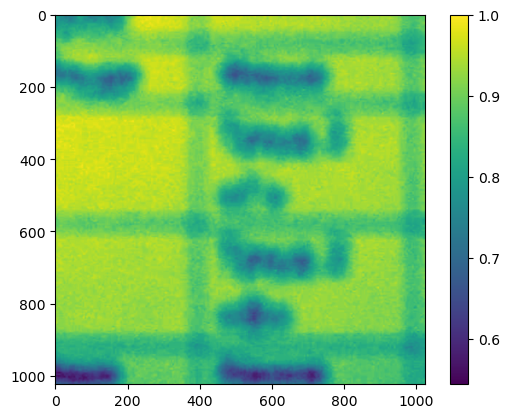

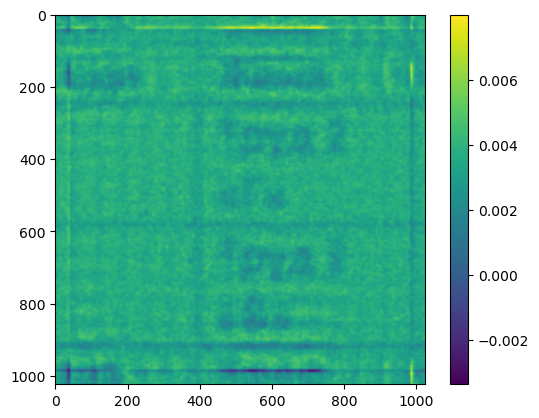

In [14]:
r = 0.077
N = 1024
u = load_image('test3.png', N)
k = kernel(r, N)

alpha = 1e-10


z = deblurring(u, k, alpha)
#z = z/np.max(z)
plt.imshow(u)
plt.colorbar()
plt.show()
plt.imshow(z)
plt.colorbar()
plt.show()

# Additional task: reg. parameter influence

Build the dependence of relative error in the solution on the regularization parameter $\alpha$ and on the noise level. Investigate the optimal parameters for different noise levels and different images. 